<a href="https://colab.research.google.com/github/blueriver212/CatAnalysis/blob/main/OrbitCallibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import sp3
from astropy.coordinates import GCRS, ITRS, CartesianRepresentation, CartesianDifferential, SkyCoord, TEME
from astropy import units
from astropy.time import Time
import numpy as np
np.set_printoptions(precision=15, suppress=True)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# now we need to propagate with sgp4 each TLE up untill the start of the next one with a timestep size of 30 seconds
import sgp4
from sgp4.api import Satrec, jday
from datetime import datetime
from sgp4.earth_gravity import wgs84
import plotly
import json
from datetime import datetime, timedelta
from dateutil.tz import tzutc
from Utilities import utc_to_jd 
import os

In [64]:
# chose the files that you want to use
RawDataFolder = 'v1'

# load the sp3 file
product = sp3.Product.from_file(os.path.join(os.getcwd(), 'RawData', RawDataFolder, 'GFZOP_RSO_L64_G_20230924_100000_20230925_000000_v03.sp3'))
start_time = product.satellites[0].records[0].time
end_time = product.satellites[0].records[-1].time
start_time_range = start_time - timedelta(days=1) # need some buffer room
end_time_range = start_time + timedelta(days=2)


with open(os.path.join(os.getcwd(), 'RawData', RawDataFolder, 'grace-fo-1-tle-43476.json'), "r") as file:
    tle_raw_l64 = json.load(file)

tles = [entry for entry in tle_raw_l64 if start_time_range <= datetime.fromisoformat(entry['EPOCH']).replace(tzinfo=tzutc()) <= end_time_range]

In [75]:
sp3_time = [result.time for result in product.satellites[0].records]
sp3_ephemeris_before_trans = []

from datetime import timedelta

from astropy.utils import iers
iers.conf.auto_download = True  

def process_raw_sp3(product):
  sp3_ephemeris = []
  for item in product.satellites[0].records:
      pos_ecef = np.array([item.position[0], item.position[1], item.position[2]])
      vel_ecef = np.array([item.velocity[0], item.velocity[1], item.velocity[2]])

      # bit more research here...
      epoch = Time(item.time) - timedelta(seconds=18)

      itrs = ITRS(
          x=item.position[0] * units.m,
          y=item.position[1] * units.m,
          z=item.position[2] * units.m,
          v_x=item.velocity[0] * units.m/units.s,
          v_y=item.velocity[1] * units.m/units.s,
          v_z=item.velocity[2] * units.m/units.s,
          representation_type='cartesian',
          differential_type='cartesian',
          obstime=epoch
      )

      gcrs = itrs.transform_to(GCRS(obstime=epoch))
      pos = np.array([gcrs.cartesian.x.value, gcrs.cartesian.y.value, gcrs.cartesian.z.value])
      vel = np.array([gcrs.velocity.d_x.value * 1000, gcrs.velocity.d_y.value * 1000, gcrs.velocity.d_z.value * 1000]) # astropy converts to km/s for some reason in the transformation

      sp3_ephemeris.append({
          'time': item.time,
          'position': pos,
          'velocity': vel
      })

  return sp3_ephemeris

sp3_ephemeris = process_raw_sp3(product)

### Time plot of data

In [76]:
import plotly.graph_objects as go

# Your existing data for sp3_ephemeris_L64
x_L64 = [entry['position'][0] for entry in sp3_ephemeris[0:100]]
y_L64 = [entry['position'][1] for entry in sp3_ephemeris[0:100]]
z_L64 = [entry['position'][2] for entry in sp3_ephemeris[0:100]]

# Extracting data for sp3_ephemeris_L65
x_L65 = [entry['position'][0] for entry in sp3_ephemeris[0:100]]
y_L65 = [entry['position'][1] for entry in sp3_ephemeris[0:100]]
z_L65 = [entry['position'][2] for entry in sp3_ephemeris[0:100]]

# Create a Plotly figure
fig = go.Figure()

# Adding trace for sp3_ephemeris_L64
fig.add_trace(go.Scatter3d(x=x_L64, y=y_L64, z=z_L64, mode='markers',
                           marker=dict(size=4, color='blue'),
                           name='Satellite L64'))

# Adding trace for sp3_ephemeris_L65
fig.add_trace(go.Scatter3d(x=x_L65, y=y_L65, z=z_L65, mode='markers',
                           marker=dict(size=4, color='red'),
                           name='Satellite L65'))

# Updating layout
fig.update_layout(
    title='3D Plot of SP3 Ephemeris Position for Two Satellites',
    scene=dict(
        xaxis_title='X Position (km)',
        yaxis_title='Y Position (km)',
        zaxis_title='Z Position (km)'
    ),
    legend_title='Satellites'
)

fig.show()


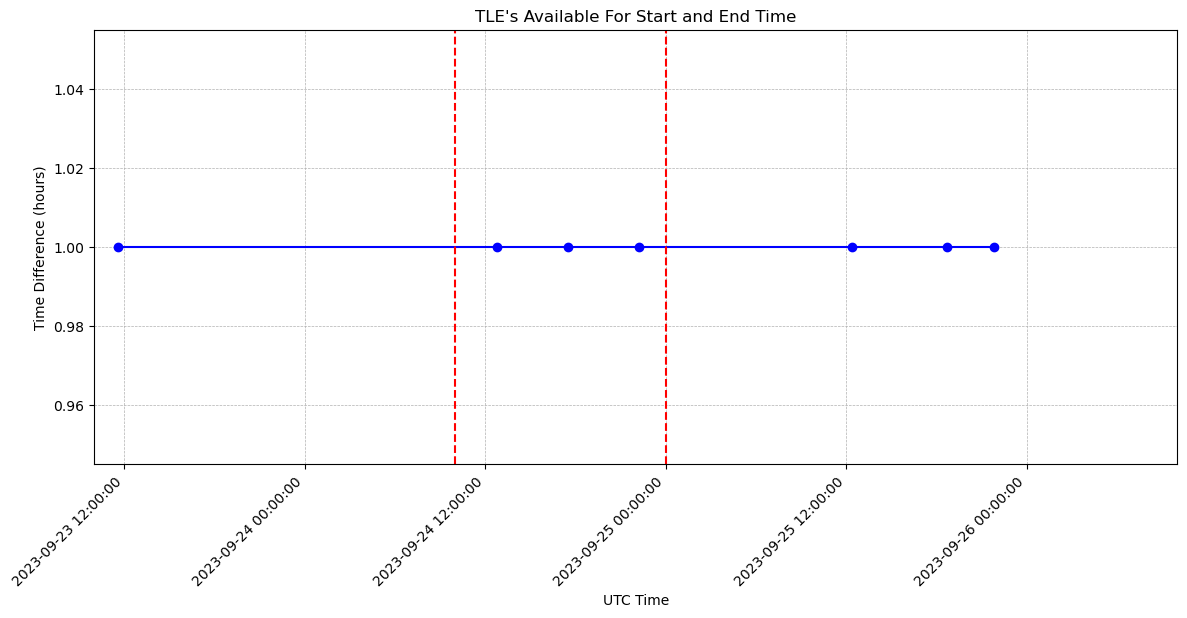

In [77]:
epoch_times = [datetime.fromisoformat(entry['EPOCH']) for entry in tles]

# Calculate time differences in hours
time_diffs = [1 for _ in epoch_times]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(epoch_times, time_diffs, marker='o', linestyle='-', color='blue')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()  # for slanting date labels
plt.title("TLE's Available For Start and End Time")
plt.xlabel("UTC Time")
plt.ylabel("Time Difference (hours)")
plt.axvline(start_time, color='red', linestyle='--', label='Start Time')
plt.axvline(end_time, color='red', linestyle='--', label='End Time')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.xticks(rotation=45)
plt.xlim(start_time_range, end_time_range)
plt.show()

In [78]:
from datetime import datetime, timedelta, timezone
import numpy as np
from astropy.time import Time
from astropy.coordinates import GCRS, ITRS
from astropy import units

def utc_to_jd(time_stamps):
    """
    Convert UTC datetime or string representations to Julian Date (JD).

    This function takes in either a single datetime, string representation of a datetime, or a list of them. It then
    converts each of these into its corresponding Julian Date (JD) value. If a list is provided, it returns a list of JD
    values. If a single datetime or string is provided, it returns a single JD value.

    :param time_stamps: The datetime object(s) or string representation(s) of dates/times to be converted to Julian Date.
                        Strings should be in the format '%Y-%m-%d' or '%Y-%m-%d %H:%M:%S'.
    :type time_stamps: datetime.datetime, str or list of datetime.datetime/str
    :return: The corresponding Julian Date (JD) value(s) for the provided datetime(s) or string representation(s).
             Returns a single float if the input is a single datetime or string, and a list of floats if the input is a list.
    :rtype: float or list of float

    .. note:: The function uses the 'astropy' library for the conversion, so ensure that 'astropy' is installed and available.
    """
    if not isinstance(time_stamps, list):
        time_stamps = [time_stamps]

    UTC_string = []
    for ts in time_stamps:
        try:
            UTC_string.append(ts.strftime('%Y-%m-%d %H:%M:%S'))
        except:
            time_str = datetime.datetime.strptime(ts, '%Y-%m-%d')
            UTC_string.append(time_str.strftime('%Y-%m-%d %H:%M:%S'))

    t = Time(UTC_string, format='iso', scale='utc')  # astropy time object
    jd = t.to_value('jd', 'long')  # convert to jd

    jd_vals = [float(j) for j in jd]

    # If the input was a single datetime, then return a single value. Otherwise, return the list.
    return jd_vals[0] if len(jd_vals) == 1 else jd_vals

In [79]:
tle_ephemeris = []
sp3_timesteps = sp3_time

# Propagate using the most up to date TLE, here the time is to go backwards through the tle list
for _sp3_time in sp3_time:
    most_recent_tle = None
    for tle in reversed(tles):
        tle_time = datetime.strptime(tle['EPOCH'], '%Y-%m-%d %H:%M:%S').replace(tzinfo=tzutc())
        if tle_time <= _sp3_time:
            most_recent_tle = tle
            break

    if not most_recent_tle:
        # Handle case where no valid TLE is found for _sp3_time
        continue

    # Propagate using SGP4 for that specific timestep with the found TLE:
    satellite = Satrec.twoline2rv(most_recent_tle['TLE_LINE1'], most_recent_tle['TLE_LINE2'])
    jd, fr = jday(_sp3_time.year, _sp3_time.month, _sp3_time.day, _sp3_time.hour, _sp3_time.minute, _sp3_time.second)
    e, r, v = satellite.sgp4(jd, fr)

    x,y,z= r[0], r[1], r[2]
    u,v,w= v[0], v[1], v[2]

    # tle data is in the TEME frame, this will need to be converted to J2000
    time = utc_to_jd(_sp3_time)
    astropy_time = Time(time, format="jd")
    #astropy_time = Time(_sp3_time)

    # convert to astropy skycoord object
    skycoord = SkyCoord(x, y, z, unit='km', representation_type='cartesian', frame=TEME(obstime=astropy_time))

    # convert to GCRS frame
    gcrs = skycoord.transform_to(GCRS(obstime=astropy_time))

    # convert to cartesian coordinates
    x, y, z = gcrs.cartesian.xyz.to(units.m)

    # convert to astropy skycoord object
    skycoord = SkyCoord(u, v, w, unit='km/s', representation_type='cartesian', frame=TEME(obstime=astropy_time))

    # convert to GCRS frame
    gcrs = skycoord.transform_to(GCRS(obstime=astropy_time))

    # convert to cartesian coordinates
    u, v, w = gcrs.cartesian.xyz.to(units.m/units.s)

    # print(r)
    # print(np.array([x.value, y.value, z.value]))

    # Store the result in the ephemeris list:
    tle_ephemeris.append({
        'time': _sp3_time,
        'position': np.array([x.value, y.value, z.value]),
        'velocity': np.array([u.value, v.value, w.value]),
    })

In [80]:
# Calculate altitudes and extract times
tle_times = [entry['time'] for entry in tle_ephemeris]
tle_altitudes = [np.linalg.norm(entry['position']) for entry in tle_ephemeris]
sp3_altitude = [np.linalg.norm(entry['position']) for entry in sp3_ephemeris]

# Plot
import plotly.graph_objects as go

# Assuming you've already calculated the sp3_altitude list and tle_altitudes list
# and you have the sp3_time and tle_times lists ready.

# Create the scatter plot
fig = go.Figure()

# Add SP3 altitude data
fig.add_trace(go.Scatter(x=sp3_time, y=sp3_altitude, mode='lines+markers',
                         name='SP3 Altitude', line=dict(color='blue')))

# Add TLE altitude data
fig.add_trace(go.Scatter(x=tle_times, y=tle_altitudes, mode='lines+markers',
                         name='TLE Altitude', line=dict(color='red')))

# Add vertical lines for start_time and end_time
fig.add_shape(
    go.layout.Shape(type="line", x0=start_time, x1=start_time, y0=min(sp3_altitude+tle_altitudes), y1=max(sp3_altitude+tle_altitudes),
                    line=dict(color="red", width=1, dash="dash"), name="Start Time")
)
fig.add_shape(
    go.layout.Shape(type="line", x0=end_time, x1=end_time, y0=min(sp3_altitude+tle_altitudes), y1=max(sp3_altitude+tle_altitudes),
                    line=dict(color="red", width=1, dash="dash"), name="End Time")
)

# Setting labels, title and layout
fig.update_layout(title='Altitude over Time',
                  xaxis_title='Time',
                  yaxis_title='Altitude (m)',
                  xaxis=dict(showgrid=True, showline=True, showticklabels=True, tickangle=45),
                  yaxis=dict(showgrid=True, showline=True, showticklabels=True),
                  showlegend=True)

# Show the interactive plot
fig.show()

## HCL Differences

In [81]:
import matplotlib.pyplot as plt

def plot_HCL(time, H_diffs, C_diffs, L_diffs):
    # Plotting H_diffs vs time
    plt.figure(figsize=(10, 6))
    plt.plot(time, H_diffs, color='red', label='H_diffs')
    plt.xlabel('Time')
    plt.ylabel('H_diffs')
    plt.title('H_diffs vs Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting C_diffs vs time
    plt.figure(figsize=(10, 6))
    plt.plot(time, C_diffs, color='blue', label='C_diffs')
    plt.xlabel('Time')
    plt.ylabel('C_diffs')
    plt.title('C_diffs vs Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting L_diffs vs time
    plt.figure(figsize=(10, 6))
    plt.plot(time, L_diffs, color='green', label='L_diffs')
    plt.xlabel('Time')
    plt.ylabel('L_diffs')
    plt.title('L_diffs vs Time')
    plt.legend()
    plt.grid(True)
    plt.show()

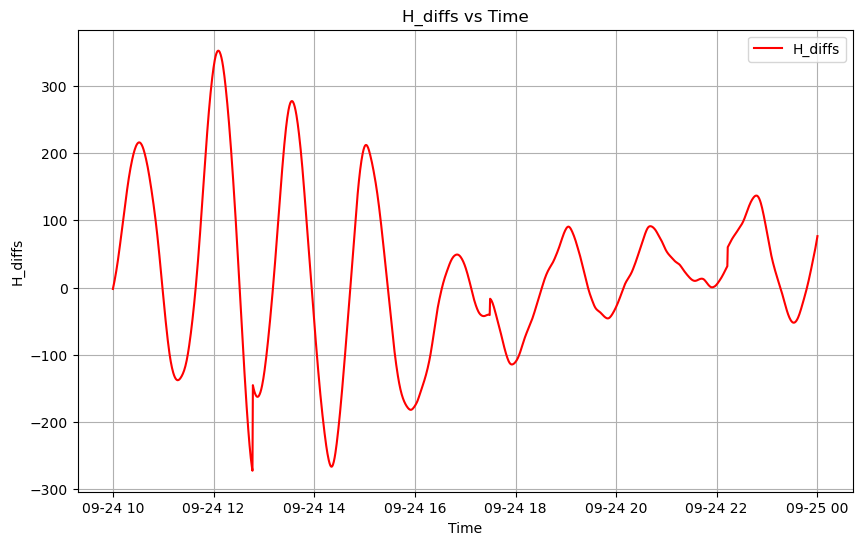

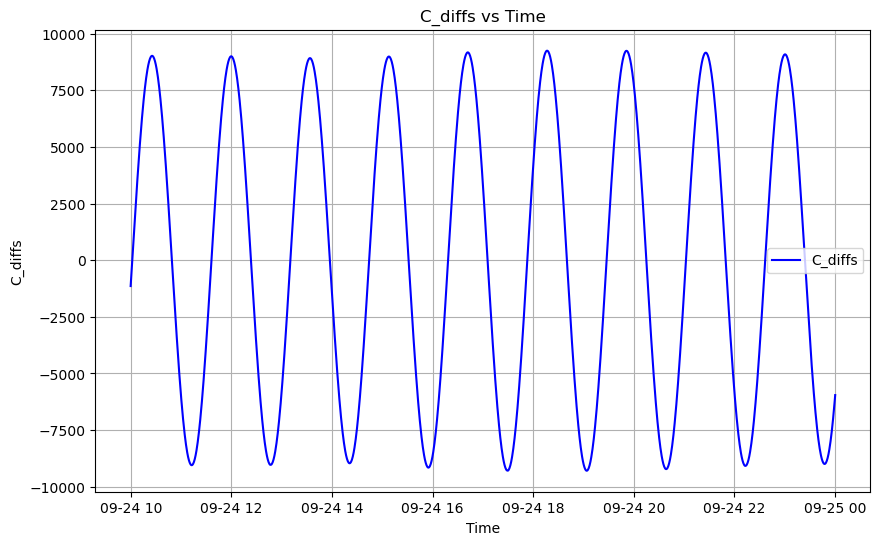

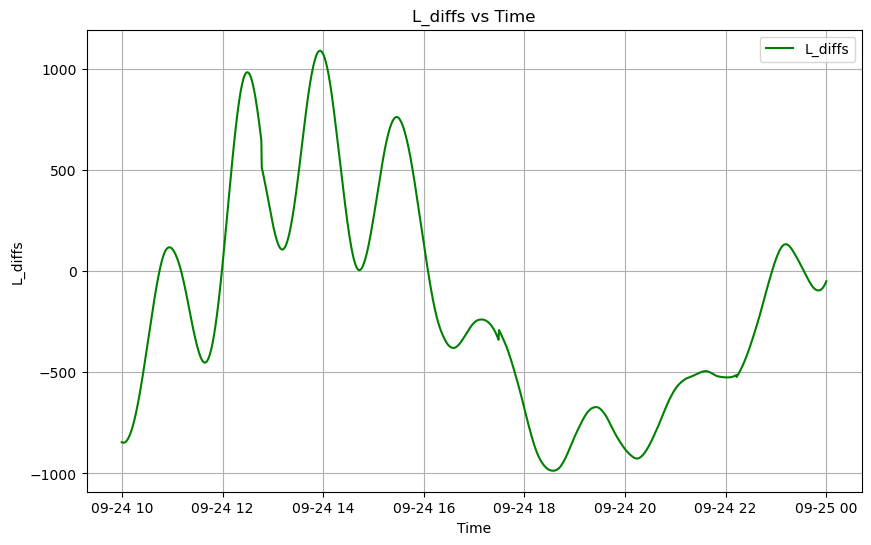

In [134]:
def HCL_diff(eph1, eph2):
    H_diffs = []
    C_diffs = []
    L_diffs = []
    time = []
    positions = []

    for i in range(0, len(eph1), 1):

        # charles 2023
        r1 = np.array(eph1[i]['position'])
        r2 = np.array(eph2[i]['position'])

        v1 = np.array(eph1[i]['velocity'])
        v2 = np.array(eph2[i]['velocity'])

        unit_radial = r1/np.linalg.norm(r1)
        unit_cross_track = np.cross(r1, v1)/np.linalg.norm(np.cross(r1, v1))
        unit_along_track = np.cross(unit_radial, unit_cross_track)

        #put the three unit vectors into a matrix
        unit_vectors = np.array([unit_radial, unit_cross_track, unit_along_track])

        #subtract the two position vectors
        r_diff = r1 - r2

        #relative position in HCL frame
        r_diff_HCL = np.matmul(unit_vectors, r_diff)

        #height, cross track and along track differences
        h_diff = r_diff_HCL[0]
        c_diff = r_diff_HCL[1]
        l_diff = r_diff_HCL[2]

        H_diffs.append(h_diff)
        C_diffs.append(c_diff)
        L_diffs.append(l_diff)
        time.append(eph1[i]['time'])
        positions.append(r1)

    return [time, H_diffs, C_diffs, L_diffs, positions] # also return the position and velocity of the TLE ephemeris for the correction mapping

HCL = HCL_diff(tle_ephemeris, sp3_ephemeris)

plot_HCL(HCL[0], HCL[1], HCL[2], HCL[3])

In [83]:
import plotly.graph_objects as go

# Your SP3 Ephemeris positions
x_sp3 = [entry['position'][0] for entry in sp3_ephemeris]
y_sp3 = [entry['position'][1] for entry in sp3_ephemeris]
z_sp3 = [entry['position'][2] for entry in sp3_ephemeris]

# Assuming you have another dataset named tle_ephemeris
x_tle = [entry['position'][0] for entry in tle_ephemeris]
y_tle = [entry['position'][1] for entry in tle_ephemeris]
z_tle = [entry['position'][2] for entry in tle_ephemeris]

# Create the plot
fig = go.Figure()

# Add SP3 Ephemeris data
fig.add_trace(go.Scatter3d(x=x_sp3, y=y_sp3, z=z_sp3, mode='markers',
                           marker=dict(size=5, color='blue', opacity=0.5), name='SP3 Ephemeris'))

# Add TLE Ephemeris data
fig.add_trace(go.Scatter3d(x=x_tle, y=y_tle, z=z_tle, mode='markers',
                           marker=dict(size=5, color='red', opacity=0.5), name='TLE Ephemeris'))

# Setting labels and title
fig.update_layout(scene=dict(xaxis_title='X Position (km)',
                             yaxis_title='Y Position (km)',
                             zaxis_title='Z Position (km)'),
                  title='3D Scatter plot of SP3 and TLE Ephemeris Positions')

# Show the interactive plot
fig.show()


In [84]:
print(sum(HCL[1]))
print(sum(HCL[2]))
print(sum(HCL[3]))

# 31446.181219834343
# 66296.84665723008
# -284318.5800838967

# 31796.481976520765
# 70644.8935244242
# -286997.8612118959


31446.181219834343
66296.84665723008
-284318.5800838967


# Mapping the Errors

Now we to map the errors between the sp3 data of the spacecraft to the TLE. 

In [126]:
from typing import List, Tuple
import numpy as np
from pyproj import Transformer

def ecef_to_lla(pos: List[float]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Convert Earth-Centered, Earth-Fixed (ECEF) coordinates to Latitude, Longitude, Altitude (LLA).

    Parameters
    ----------
    x : List[float]
        x coordinates in km.
    y : List[float]
        y coordinates in km.
    z : List[float]
        z coordinates in km.

    Returns
    -------
    tuple
        Latitudes in degrees, longitudes in degrees, and altitudes in km.
    """
    
    # Create a transformer for converting between ECEF and LLA
    transformer = Transformer.from_crs(
        "EPSG:4978", # WGS-84 (ECEF)
        "EPSG:4326", # WGS-84 (LLA)
        always_xy=True # Specify to always return (X, Y, Z) ordering
    )

    # Convert coordinates
    lat = []
    lon = []
    alt_km = []

    for i in pos:
        lon_temp, lat_temp, alt_m_temp = transformer.transform(i[0], i[1], i[2])
        lat.append(lat_temp)
        lon.append(lon_temp)
        alt_km.append(alt_m_temp * 0.001)

    return lat, lon, alt_km


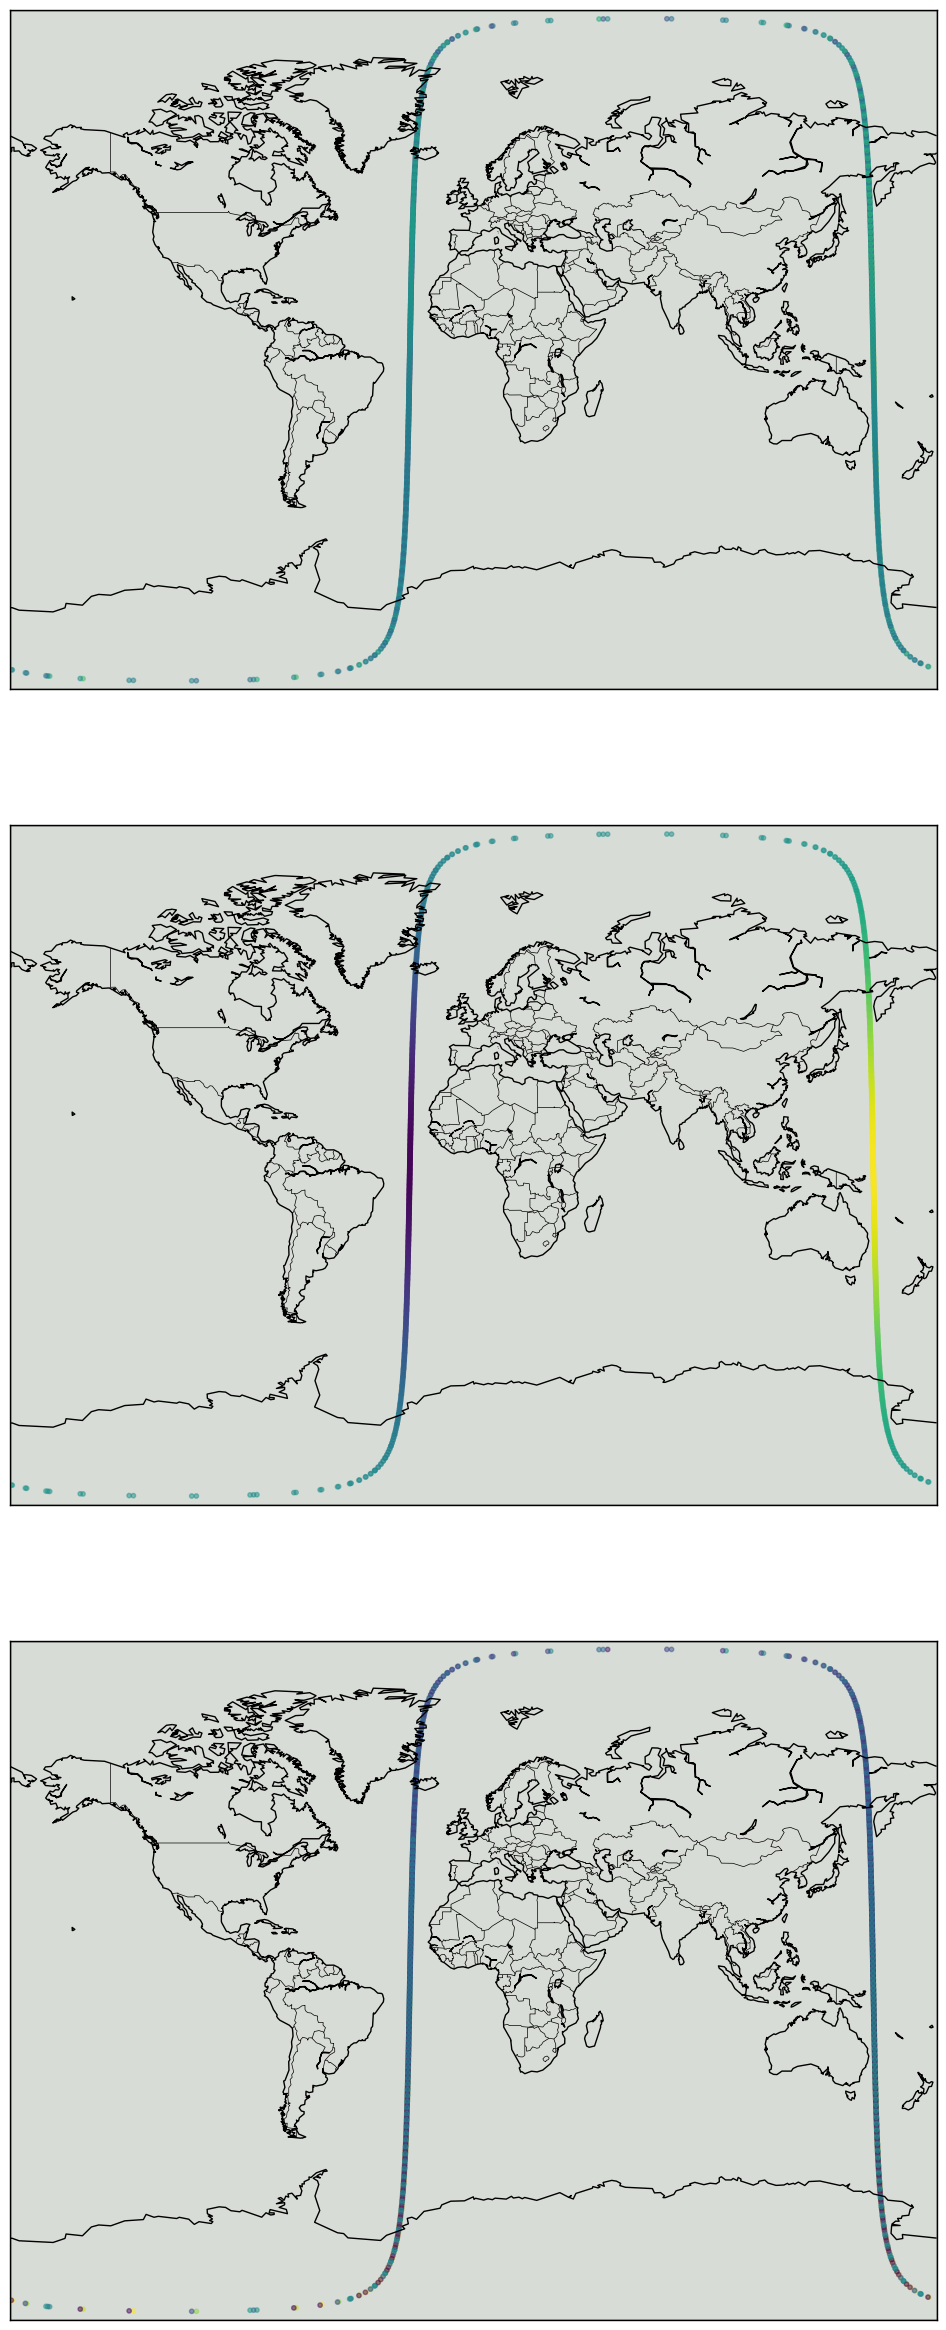

In [146]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

transformer = Transformer.from_crs(
    "EPSG:4978", # WGS-84 (ECEF)
    "EPSG:4326", # WGS-84 (LLA)
    always_xy=True # Specify to always return (X, Y, Z) ordering
)

time, H_diffs, C_diffs, L_diffs, positions = HCL[0], HCL[1], HCL[2], HCL[3], HCL[4]

# Convert positions to lat, lon
lats, lons = [], []
for position in positions:
    lat, lon, _ = transformer.transform(position[0], position[1], position[2])
    lats.append(lat)
    lons.append(lon)

# Prepare the Basemap for each dataset
fig, axes = plt.subplots(3, 1, figsize=(15, 30))  # 3 maps in a column

# Plotting H_diffs, C_diffs, and L_diffs on separate maps
for i, diffs in enumerate([H_diffs, C_diffs, L_diffs]):
    m = Basemap(projection='mill', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c', ax=axes[i])
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='xkcd:light grey')

    # Scatter plot
    xpt, ypt = m(lats, lons )
    m.scatter(xpt, ypt, c=diffs, alpha=0.5, s=10)  # Adjust size and alpha as needed

plt.show()